## Data Preparation

https://pennylane.ai/qml/demos/tutorial_variational_classifier.html#id3

In [1]:
!pip install pennylane qiskit qiskit_machine_learning imblearn plotly seaborn
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import QuantumKernel

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist

from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/4

In [2]:
X = pd.read_csv("/kaggle/input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("/kaggle/input/logstdvif/y.csv")
df=pd.concat([X,y],axis=1)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

X = pd.read_csv("/kaggle/input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("/kaggle/input/logstdvif/y.csv", index_col=None)['went_on_backorder']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No backorder', round(y.value_counts()[0]/len(y) * 100,2), '% of the dataset')
print('Backorder', round(y.value_counts()[1]/len(y) * 100,2), '% of the dataset')

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No backorder 99.3 % of the dataset
Backorder 0.7 % of the dataset
Train: [ 259572  259620  259654 ... 1775315 1775316 1775317] Test: [     0      1      2 ... 355895 355896 355897]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [259572 259620 259654 ... 711229 711230 711231]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 562975  562992  563216 ... 1066527 1066528 1066529]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 913555  913679  913781 ... 1549977 1550291 1550807]
Train: [      0       1       2 ... 1549977 1550291 1550807] Test: [1420136 1420137 1420138 ... 1775315 1775316 1775317]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99296253 0.00703747]
[0.99296181 0.00703819]


In [3]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))
print("Before UnderSampling, counts of label '1': {}".format(sum(original_ytrain == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(original_ytrain == 0)))

Length of X (train): 1420255 | Length of y (train): 1420255
Length of X (test): 355063 | Length of y (test): 355063
Before UnderSampling, counts of label '1': 9995
Before UnderSampling, counts of label '0': 1410260 



In [4]:
print("test, counts of label '1': {}".format(sum(original_ytest == 1)))
print("test, counts of label '0': {} \n".format(sum(original_ytest == 0)))

test, counts of label '1': 2499
test, counts of label '0': 352564 



{0:17628,1:125} => 2499/20 and 352564/20

In [5]:
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, RandomizedSearchCV

sm1 = NearMiss(sampling_strategy={0:500,1:500}) # 500:500
Xsm_train, ysm_train = sm1.fit_resample(original_Xtrain, original_ytrain)
sm2 = NearMiss(sampling_strategy={0:200,1:67}) # 200:200
Xsm_test, ysm_test = sm2.fit_resample(original_Xtest, original_ytest)

In [6]:
print('After Sampling, the shape of train_X: {}'.format(Xsm_train.shape))
print('After Sampling, the shape of train_y: {} \n'.format(ysm_train.shape))

print("After Sampling, counts of label '1': {}".format(sum(ysm_train == 1)))
print("After Sampling, counts of label '0': {}".format(sum(ysm_train == 0)))

print('After Sampling, the shape of test_X: {}'.format(Xsm_test.shape))
print('After Sampling, the shape of test_y: {} \n'.format(ysm_test.shape))

print("After Sampling, counts of label '1': {}".format(sum(ysm_test == 1)))
print("After Sampling, counts of label '0': {}".format(sum(ysm_test == 0)))

After Sampling, the shape of train_X: (1000, 14)
After Sampling, the shape of train_y: (1000,) 

After Sampling, counts of label '1': 500
After Sampling, counts of label '0': 500
After Sampling, the shape of test_X: (267, 14)
After Sampling, the shape of test_y: (267,) 

After Sampling, counts of label '1': 67
After Sampling, counts of label '0': 200


# VQC
"RY-CNOT Variational Quantum Circuit Classifier" or a "Rot-CNOT Variational Quantum Circuit Classifier." These names highlight the use of RY gates and CNOT gates in the circuit structure, providing more detailed information about the architecture of the model.

In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, GradientDescentOptimizer, AdamOptimizer, MomentumOptimizer, AdaptiveOptimizer, AdagradOptimizer, RotosolveOptimizer

In [85]:
n_wires = 4
dev = qml.device("default.qubit", wires=n_wires)

def block(weights, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    
n_block_wires = 2
n_params_block = 2
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
n_blocks


### ALL VQC changes take place here #####
@qml.qnode(dev)
def circuit(weights, x):
    qml.AmplitudeEmbedding(x, wires=[0,1,2,3],normalize=True,pad_with=True)
    for w in weights:
        qml.MERA(range(n_wires),n_block_wires,block, n_params_block, w)
        #print(w)
    #print(x)
    return qml.expval(qml.PauliZ(1))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


In [86]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


In [87]:
np.random.seed(0)
num_layers = 2
weights_init = 2*np.pi * np.random.randn(num_layers,n_blocks, n_params_block, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[11.08386778  2.51426189]
  [ 6.14959212 14.07994722]
  [11.73421292 -6.14041802]
  [ 5.96958159 -0.95100539]
  [-0.64854317  2.57986647]]

 [[ 0.90505245  9.13746993]
  [ 4.78174105  0.76450668]
  [ 2.78887494  2.09653763]
  [ 9.38757568 -1.28904739]
  [ 1.96706238 -5.3664418 ]]] 0.0


In [88]:
print(qml.draw(circuit,expansion_strategy='device')(weights_init,np.asarray(Xsm_train[0])))

0: ─╭QubitStateVector(M0)─╭X──RY(2.51)────────────────╭●──RY(5.97)──╭●──RY(-0.65)─╭X──RY(9.14)───
1: ─├QubitStateVector(M0)─╰●──RY(11.08)─╭X──RY(-6.14)─│─────────────╰X──RY(2.58)──╰●──RY(0.91)─╭X
2: ─├QubitStateVector(M0)─╭●──RY(6.15)──│─────────────╰X──RY(-0.95)─╭●──RY(4.78)───────────────│─
3: ─╰QubitStateVector(M0)─╰X──RY(14.08)─╰●──RY(11.73)───────────────╰X──RY(0.76)───────────────╰●

────────────╭●──RY(9.39)──╭●──RY(1.97)──┤     
───RY(2.10)─│─────────────╰X──RY(-5.37)─┤  <Z>
────────────╰X──RY(-1.29)───────────────┤     
───RY(2.79)─────────────────────────────┤     


In [89]:
for i in weights_init:
    print(i[0])

[11.08386778  2.51426189]
[0.90505245 9.13746993]


In [90]:
ysm_train = np.where(ysm_train < 1, -1, ysm_train)
ysm_test = np.where(ysm_test < 1, -1, ysm_test)

In [91]:
from sklearn.utils import shuffle
X,y = shuffle(Xsm_train, ysm_train, random_state=0)

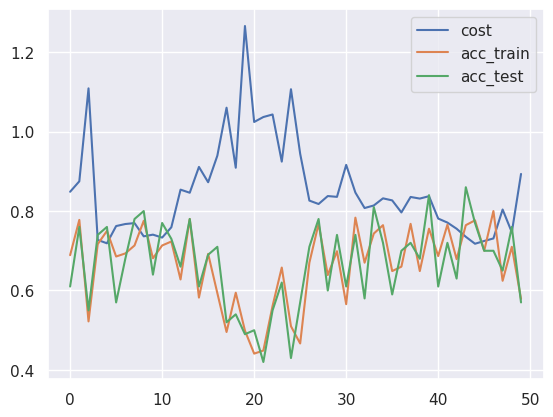

Iter:    50 | Cost: 0.8934037 | Acc train: 0.5788889 | Acc validation: 0.5700000 
[[[ 6.28045035  3.98889232]
  [ 4.94713817 15.03819608]
  [ 9.26080411 -8.71123488]
  [ 8.32805413 -0.43099169]
  [ 0.22463139  2.9336197 ]]

 [[ 2.2727793  10.5919283 ]
  [ 5.05430877 -2.16656578]
  [ 2.78887494 -0.98377426]
  [10.839293   -1.28904739]
  [ 1.96706238 -0.48815862]]]


In [92]:
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
clear_output(wait=False)

opt = NesterovMomentumOptimizer(0.4)
batch_size = 32

num_data = len(ysm_train)
num_train = 0.9
# train the variational classifier
weights = weights_init
bias = bias_init
print()

cost_g = []
acc_train = []
acc_test = []
plt.show()
for it in range(50):
    X_train_70, X_test_30, y_train_70, y_test_30 =train_test_split(np.asarray(X), np.asarray(y), train_size=num_train, test_size=1.0-num_train, shuffle=True)
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train_70), (batch_size,))
    feats_train_batch = X_train_70[batch_index]
    Y_train_batch = y_train_70[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train_70]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_test_30]
    # Compute accuracy on train and validation set
    acc_tra = accuracy(y_train_70, predictions_train)
    acc_val = accuracy(y_test_30, predictions_val)
    cost_train = cost(weights, bias,Xsm_train, ysm_train)
    cost_g.append(cost_train)
    
    acc_train.append(acc_tra)
    acc_test.append(acc_val)
    
    clear_output(wait=True)
    plt.plot(cost_g,label='cost')
    plt.plot(acc_train,label='acc_train')
    plt.plot(acc_test,label='acc_test')
    plt.legend(['cost','acc_train','acc_test'])
    plt.show()
     
    
    print(
         "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost_train, acc_tra, acc_val)
     )
    print(weights)

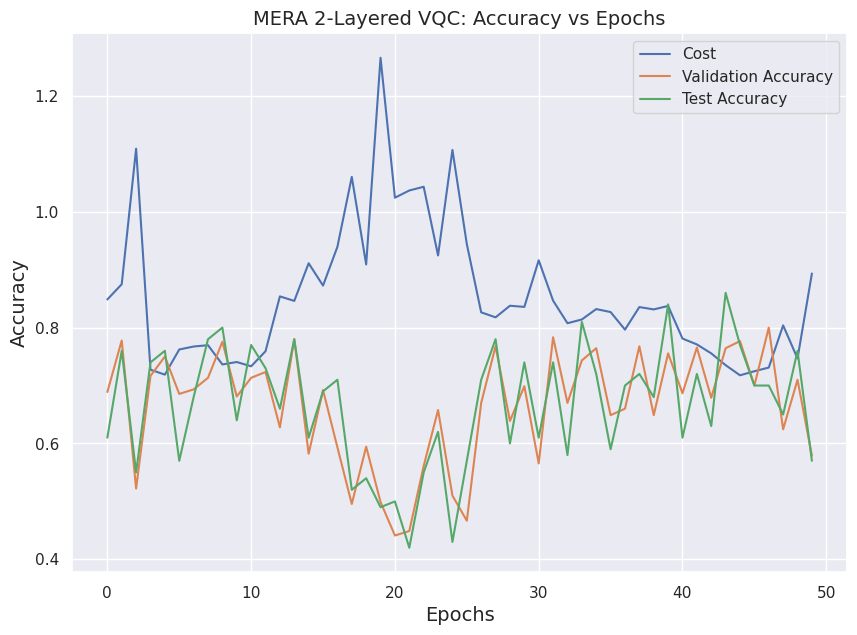

In [94]:
plt.figure(figsize=[10,7])
plt.plot(cost_g,label='Cost')
plt.plot(acc_train,label='Train Accuracy')
plt.plot(acc_test,label='Validation Accuracy')
plt.title("MERA 2-Layered VQC: Accuracy vs Epochs",fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend(['Cost','Validation Accuracy','Test Accuracy'])
plt.show()

In [95]:
x_test = []
for x in Xsm_test.tolist():
    if sum(x) == 0:
        x[0]=1
    x_test.append( x/ np.linalg.norm(x))
x_test[0]

array([ 0.01919983, -0.63115174,  0.38150674, -0.17221453, -0.22760679,
       -0.37740984, -0.26502463, -0.04219778, -0.03361119,  0.        ,
        0.        ,  0.        ,  0.        ,  0.39834928])

In [96]:
y_pred = [np.sign(variational_classifier(weights, bias, f)) for f in x_test]

In [97]:
y_test_pred = []
for i in y_pred:
    if i < 0:
        y_test_pred.append(-1)
    else:
        y_test_pred.append(1)

In [98]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(ysm_test, y_test_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ysm_test, y_test_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ysm_test, y_test_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ysm_test, y_test_pred)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(ysm_test, y_test_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(ysm_test, y_test_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
test_matrix = confusion_matrix(ysm_test, y_test_pred)
print(test_matrix)

Accuracy: 0.423221
Precision: 0.279188
Recall: 0.820896
F1 score: 0.416667
Cohens kappa: 0.067408
ROC AUC: 0.555448
[[ 58 142]
 [ 12  55]]


In [99]:
from sklearn.metrics import classification_report
classes=['No Backorder','Backorder']
print(classification_report(ysm_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.83      0.29      0.43       200
           1       0.28      0.82      0.42        67

    accuracy                           0.42       267
   macro avg       0.55      0.56      0.42       267
weighted avg       0.69      0.42      0.43       267



In [100]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(ysm_test, y_test_pred))

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.83      0.29      0.82      0.43      0.49      0.23       200
          1       0.28      0.82      0.29      0.42      0.49      0.25        67

avg / total       0.69      0.42      0.69      0.43      0.49      0.23       267



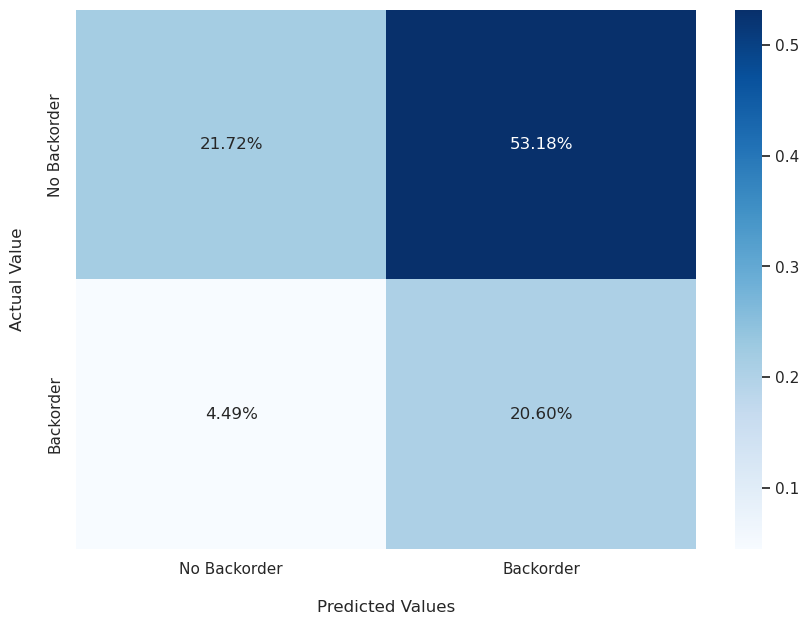

In [101]:
plt.figure(figsize=[10,7])
ax = sns.heatmap(test_matrix/np.sum(test_matrix), annot=True, cmap='Blues', fmt='0.2%')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Value\n');

ax.xaxis.set_ticklabels(['No Backorder','Backorder'])
ax.yaxis.set_ticklabels(['No Backorder','Backorder'])

## Display the visualization of the Confusion Matrix.
plt.show()